# Homework 4

### Imports

In [22]:
import numpy as np
from numpy.linalg import norm
import scipy
from scipy.special import expit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings #To ignore warnings for final submission

### Ignore Warnings

In [23]:
warnings.filterwarnings('ignore')

### Code from objectives.py

In [24]:
def get_rosenbrock(d):
    def f(x):
        coupled_term = 100*(x[1:]**2-x[:-1])**2
        diagonal_term = (x  - 1.)**2
        return np.sum(coupled_term) + np.sum(diagonal_term)
    
    def gradf(x):
        grad = 2.0 * (x - 1.0)
        diffs = x[1:]**2 - x[:-1]
        grad[:-1] += -200.0 * diffs
        grad[1:]  += 400.0 * x[1:] * diffs
        return grad
    
    def hessf(x):
        diag_main = np.full(d, 2.0)
        diag_main[:-1] += 200.0
        diag_main[1:] += 1200.0 * x[1:]**2 - 400.0 * x[:-1]
        off_diag = np.zeros(d - 1)
        off_diag = -400.0 * x[1:]
        H = (
            np.diag(diag_main) +
            np.diag(off_diag, k=1) +
            np.diag(off_diag, k=-1)
        )
        return H
    x0 = -1 * np.ones(d)
    
    return f,gradf,hessf,x0


#MNIST Logistic regression
mnist_data = np.load('mnist01.npy',allow_pickle=True)
#
A_lgt = mnist_data[0]
b_lgt = mnist_data[1]



def get_lgt_obj(lam_lgt):
    x0 = np.zeros(A_lgt.shape[1]) #Alex told me to do this.
    # define function, gradient and Hessian
    def lgt_func(x):
        y = A_lgt.dot(x)
        return np.sum(np.log1p(np.exp(y))) - b_lgt.dot(y) + 0.5 * lam_lgt * np.sum(x**2)
    #
    def lgt_grad(x):
        y = A_lgt.dot(x)
        z = expit(y) - b_lgt
        return A_lgt.T.dot(z) + lam_lgt*x
    #
    def lgt_hess(x):
        y = A_lgt.dot(x)
        z = expit(y) * (1-expit(y))
        return A_lgt.T.dot(np.diag(z).dot(A_lgt)) + lam_lgt*np.eye(x.size)
    
    return lgt_func,lgt_grad,lgt_hess,x0


### Implement Bisection Line Search with Weak Wolfe Conditions

In [25]:
def bisection_linesearch(x, d, f, gradf, c0=0.1, c1=0.9, t0=1.0): #The Professor says that I might be overflowing.
    a, b = 0, np.inf
    t = t0  # Initial step size
    kendrick_lamar = 0
    
    while True:
        new_x = x + t * d
        fval = f(new_x)
        g = gradf(new_x)
        W1 = (fval - f(x)) / (t * np.dot(d, gradf(x)))
        W2 = np.dot(d, g) / np.dot(d, gradf(x))
        if np.isnan(fval):
            t = t * 0.5  # Reduce step size if function returns NaN
            continue
                
        if W1 < c0:
            b = t
            t = max((a + b) / 2, 1e-8)  # Prevents t from becoming 0
        elif W2 > c1:
            a = t
            t = max(min(2 * a, (a + b) / 2), 1e-8)  # Prevents t from becoming 0
        else:
            break  # Wolfe conditions satisfied
        
        kendrick_lamar = kendrick_lamar+1
        if (kendrick_lamar>20): break

    return t, fval, g

### From Task Two: Steepest Descent

In [26]:
def steepest_descent(x0, f, gradf, c0=0.1, c1=0.9, t0=1.0, tol=1e-6, max_iter=1000):
    x = x0.copy()
    function_history = [f(x)]
    gradient_norms = [np.linalg.norm(gradf(x))]
    cumulative_times = [0]

    for k in range(max_iter):
        g = gradf(x)
        if np.linalg.norm(g) < tol:
            break
        direction = -g  # Steepest descent direction
        alpha, fval, g_new = bisection_linesearch(x, direction, f, gradf, c0, c1, t0)
        x = x + alpha * direction

        function_history.append(fval)
        gradient_norms.append(np.linalg.norm(g_new))

    return x, function_history, gradient_norms


### From Task Two: Newton's Method

In [27]:
def newton(x0, f, gradf, hessf, c0=0.1, c1=0.9, t0=1.0, tol=1e-6, max_iter=1000):
    x = x0.copy()
    function_history = [f(x)]
    gradient_norms = [np.linalg.norm(gradf(x))]

    for k in range(max_iter):
        g = gradf(x)
        H = hessf(x)

        if np.linalg.norm(g) < tol:
            break

        try:
            d = -np.linalg.solve(H, g)  # Solve Newton direction
        except np.linalg.LinAlgError:
            d = -g  # Fall back to steepest descent if Hessian is singular

        alpha, fval, g_new = bisection_linesearch(x, d, f, gradf, c0, c1, t0)
        x = x + alpha * d

        function_history.append(fval)
        gradient_norms.append(np.linalg.norm(g_new))

    return x, function_history, gradient_norms


### From Task Two: DFP

In [28]:
def dfp(x0, f, gradf, c0=0.1, c1=0.9, t0=1.0, tol=1e-6, max_iter=1000):
    x = x0.copy()
    n = len(x0)
    B = np.eye(n)  # Initial inverse Hessian approximation

    function_history = [f(x)]
    gradient_norms = [np.linalg.norm(gradf(x))]

    for k in range(max_iter):
        g = gradf(x)
        if np.linalg.norm(g) < tol:
            break

        d = -B @ g  # Search direction
        alpha, fval, g_new = bisection_linesearch(x, d, f, gradf, c0, c1, t0)
        s = (alpha * d).reshape(-1, 1)  # Ensure s is a column vector
        x = x + s.flatten()  # Flatten back to row vector
        y = (g_new - g).reshape(-1, 1)  # Ensure y is a column vector

        # Compute update rule safely
        B = B - (B @ y @ y.T @ B) / (y.T @ B @ y + 1e-10) + (s @ s.T) / (y.T @ s + 1e-10)

        function_history.append(fval)
        gradient_norms.append(np.linalg.norm(g_new))

    return x, function_history, gradient_norms

### From Task Two: BFGS

In [29]:
def bfgs(x0, f, gradf, c0=0.1, c1=0.9, t0=1.0, tol=1e-6, max_iter=1000):
    x = x0.copy()
    n = len(x0)
    B = np.eye(n)

    function_history = [f(x)]
    gradient_norms = [np.linalg.norm(gradf(x))]

    for k in range(max_iter):
        g = gradf(x)
        if np.linalg.norm(g) < tol:
            break

        d = -B @ g
        alpha, fval, g_new = bisection_linesearch(x, d, f, gradf, c0, c1, t0)
        s = alpha * d
        x = x+s
        y = g_new - g

        rho = 1.0 / (y.T @ s)
        B = (np.eye(n) - rho * np.outer(s, y)) @ B @ (np.eye(n) - rho * np.outer(y, s)) + rho * np.outer(s, s)

        function_history.append(fval)
        gradient_norms.append(np.linalg.norm(g_new))

    return x, function_history, gradient_norms

### Testing on Rosenbrock Function

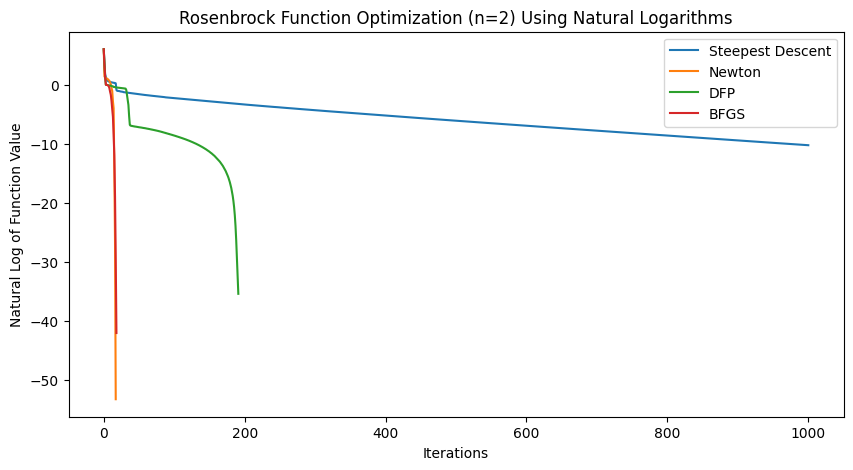

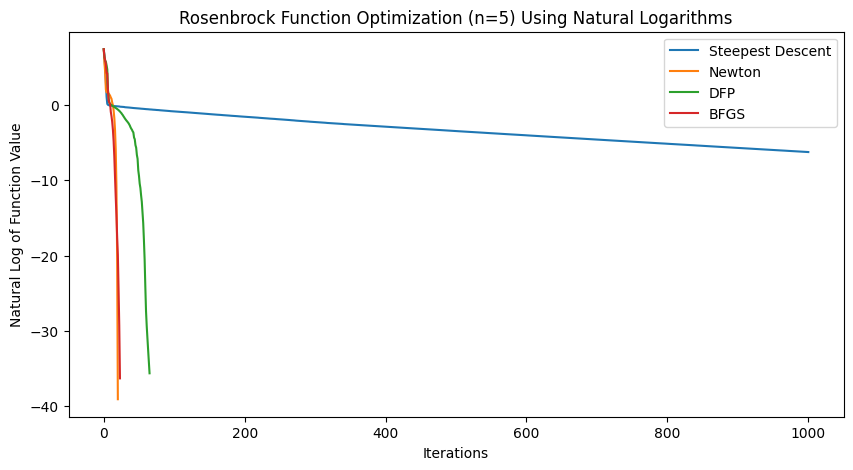

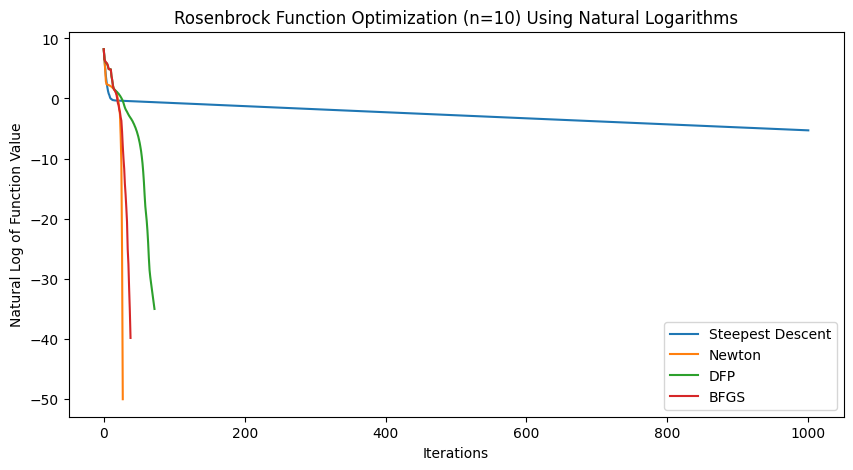

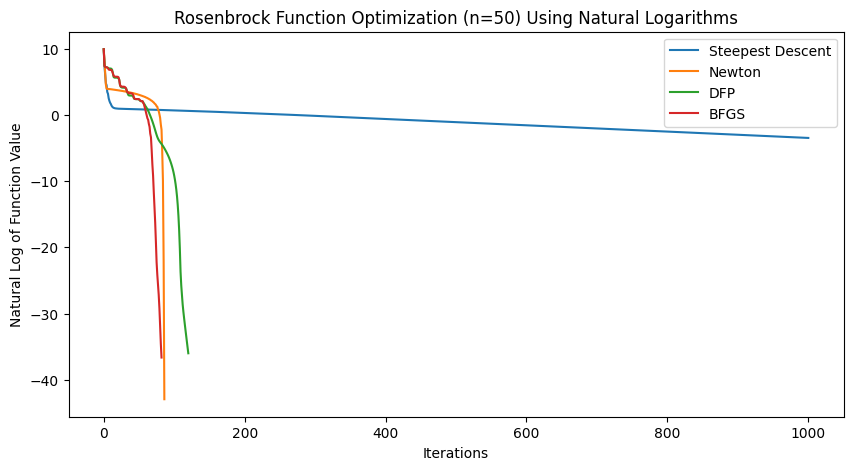

In [30]:
money_for_fun = [2, 5, 10, 50]
methods = {"Steepest Descent": steepest_descent, "Newton": newton, "DFP": dfp, "BFGS": bfgs}

for i in money_for_fun:
    f, gradf, hessf, x0 = get_rosenbrock(i)
    
    plt.figure(figsize=(10, 5))

    for method_name, method in methods.items():
        if method_name == "Newton":
            x_opt, function_history, gradient_norms = method(x0, f, gradf, hessf)
        else:
            x_opt, function_history, gradient_norms = method(x0, f, gradf)

        plt.plot(range(len(function_history)), np.log(function_history), label=method_name)

    plt.xlabel("Iterations")
    plt.ylabel("Natural Log of Function Value")
    plt.title(f"Rosenbrock Function Optimization (n={i}) Using Natural Logarithms")
    plt.legend()
    plt.show()
    #Plot the log of the function value; not the function value

### Testing on MNIST Logistic Regression

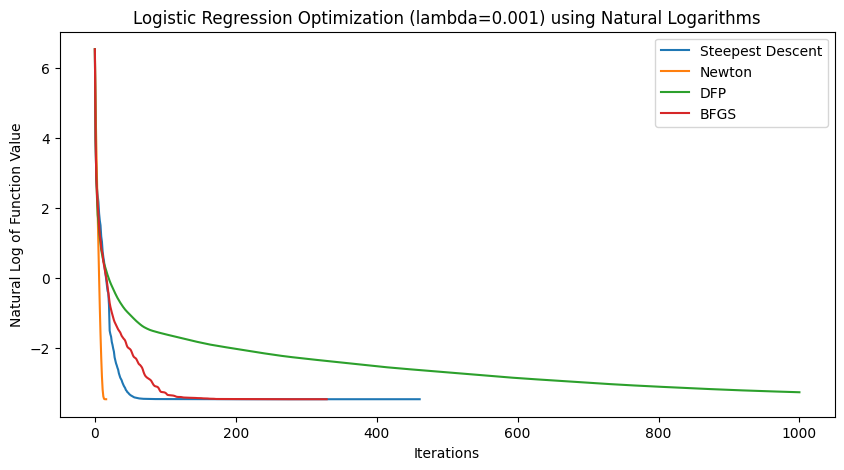

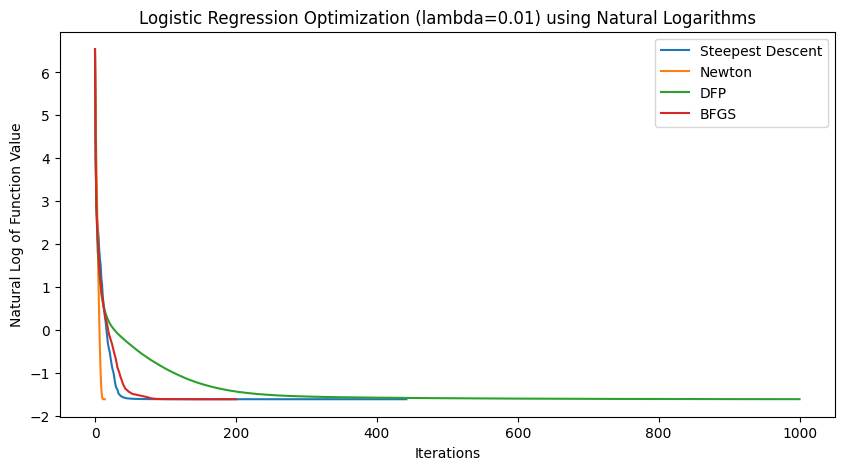

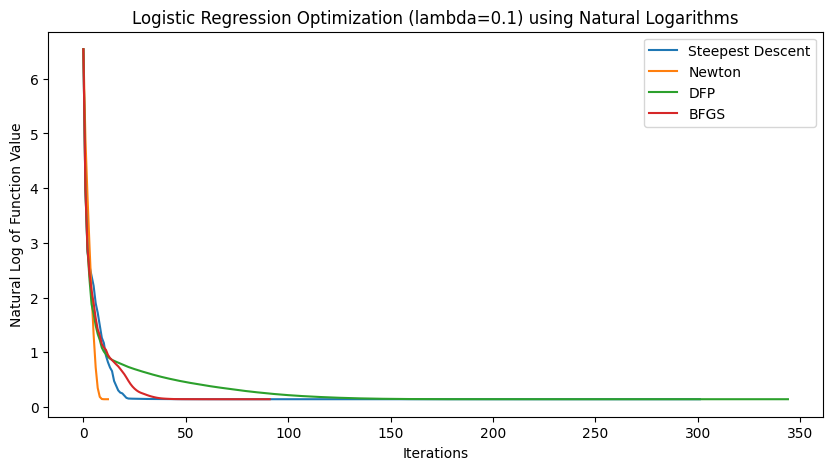

In [31]:
lam_values = [0.001, 0.01, 0.1]

for lam_lgt in lam_values:
    outer_loop_counter = 0
    f, gradf, hessf, x0 = get_lgt_obj(lam_lgt)
    plt.figure(figsize=(10, 5))

    for method_name, method in methods.items():
        inner_loop_counter = 0
        if method_name == "Newton":
            x_opt, function_history, gradient_norms = method(x0, f, gradf, hessf)
        else:
            x_opt, function_history, gradient_norms = method(x0, f, gradf) #Dimension of A is correct but x is not; x should be 784 dimensional

        plt.plot(range(len(function_history)), np.log(function_history), label=method_name) #Consider plotting the norm of the gradient.
        inner_loop_counter = inner_loop_counter + 1
        
    outer_loop_counter = outer_loop_counter + 1

    plt.xlabel("Iterations")
    plt.ylabel("Natural Log of Function Value")
    plt.title(f"Logistic Regression Optimization (lambda={lam_lgt}) using Natural Logarithms")
    plt.legend()
    plt.show()

### Ackley Function

In [48]:
def get_ackley(d, a=20, b=0.2, c=2*np.pi):
    def f(x):
        sum_sq_term = -a * np.exp(-b * np.sqrt(np.sum(x**2) / d))
        cos_term = -np.exp(np.sum(np.cos(c * x)) / d)
        return sum_sq_term + cos_term + a + np.exp(1)

    def gradf(x):
        sum_sq_term = (2 * b / d) * np.exp(-b * np.sqrt(np.sum(x**2) / d)) * (x / (np.sqrt(np.sum(x**2) + 1e-8)))
        cos_term = (c / d) * np.exp(np.sum(np.cos(c * x)) / d) * np.sin(c * x)
        return sum_sq_term + cos_term

    def hessf(x):
        diag_term = (2 * b / d) * np.exp(-b * np.sqrt(np.sum(x**2) / d))
        diag_term = diag_term * ((1 / np.sqrt(np.sum(x**2) + 1e-8)) - (x**2 / (np.sum(x**2) + 1e-8)**(3/2)))
        cos_term = -(c**2 / d) * np.exp(np.sum(np.cos(c * x)) / d) * np.sin(c * x)  # Fix the sign!
        return np.diag(diag_term) + np.diag(cos_term)

    x0 = np.random.uniform(-5, 5, d)  # Initial point randomly chosen in search space

    return f, gradf, hessf, x0

for i in range(2, 6):
    d = i
    print("Number of Dimensions: "+str(d))
    f_ack, gradf_ack, hessf_ack, x0_ack = get_ackley(d)
    print("Ackley Function Test:")
    print("f(x0):", f_ack(x0_ack))
    print("Gradient Norm at x0:", np.linalg.norm(gradf_ack(x0_ack)))
    print("Hessian at x0:\n", hessf_ack(x0_ack))
    print()

Number of Dimensions: 2
Ackley Function Test:
f(x0): 9.684621694099041
Gradient Norm at x0: 2.4696033601135365
Hessian at x0:
 [[-11.38703077   0.        ]
 [  0.           9.83212428]]

Number of Dimensions: 3
Ackley Function Test:
f(x0): 11.05739567440051
Gradient Norm at x0: 3.7559217495220283
Hessian at x0:
 [[16.72816444  0.          0.        ]
 [ 0.         -2.27599577  0.        ]
 [ 0.          0.         16.95623356]]

Number of Dimensions: 4
Ackley Function Test:
f(x0): 11.28769581323352
Gradient Norm at x0: 1.5167838725843785
Hessian at x0:
 [[-6.01728516  0.          0.          0.        ]
 [ 0.         -4.42236218  0.          0.        ]
 [ 0.          0.         -4.34513202  0.        ]
 [ 0.          0.          0.          4.14741686]]

Number of Dimensions: 5
Ackley Function Test:
f(x0): 7.502076421302988
Gradient Norm at x0: 3.1705678967061948
Hessian at x0:
 [[10.46764811  0.          0.          0.          0.        ]
 [ 0.          9.92008302  0.          0.   

### Ackley for Plotting

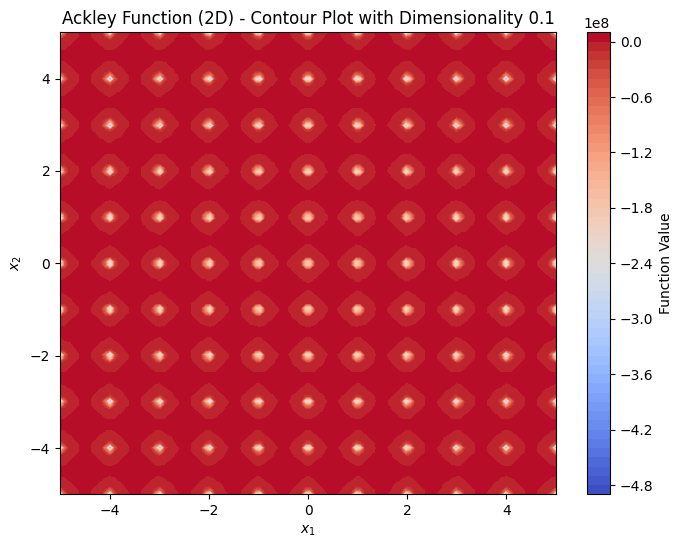

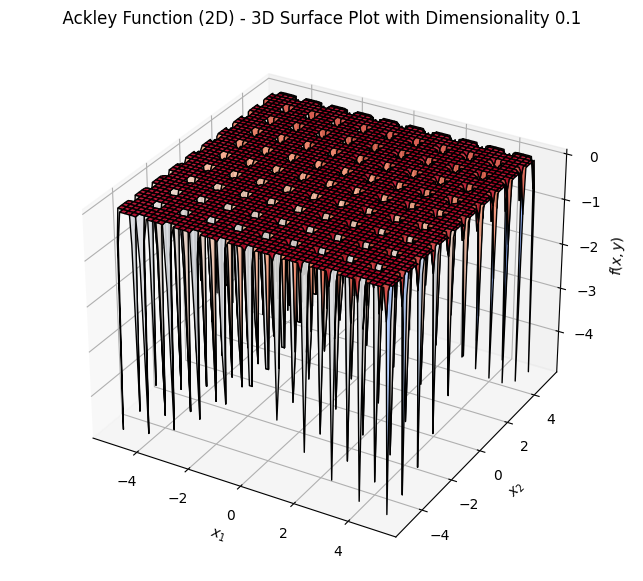

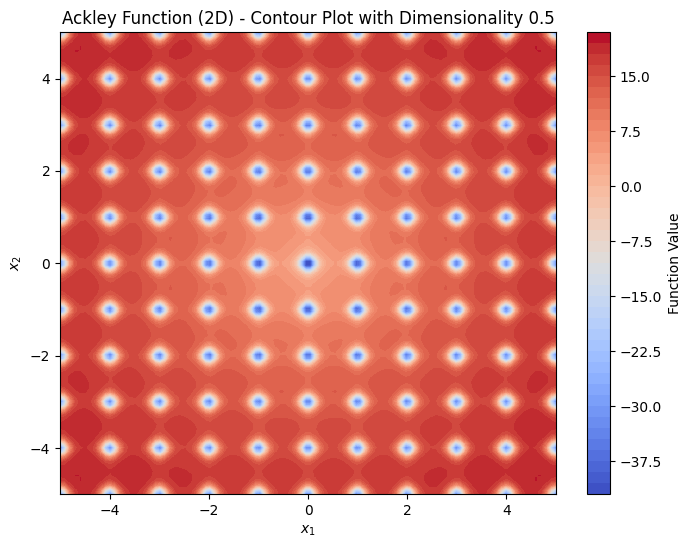

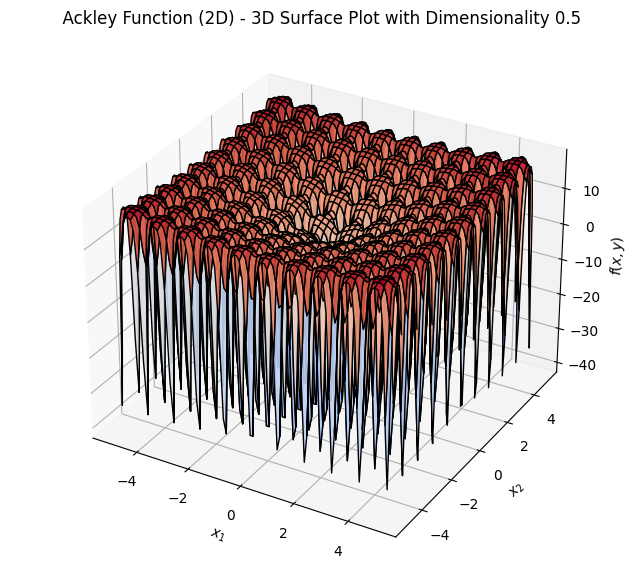

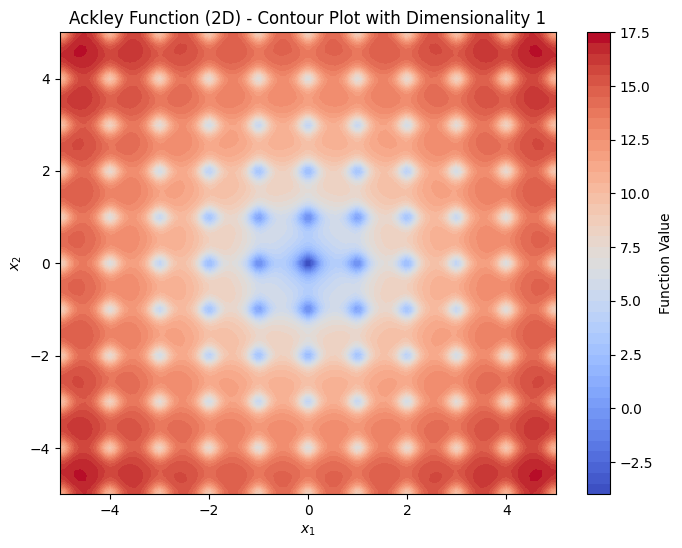

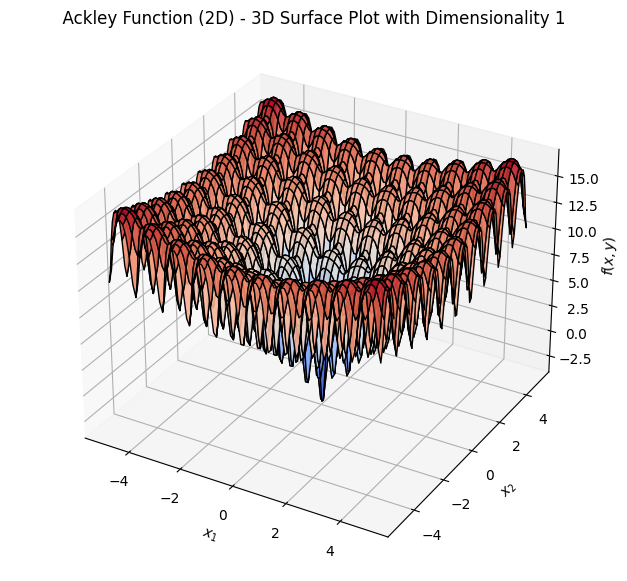

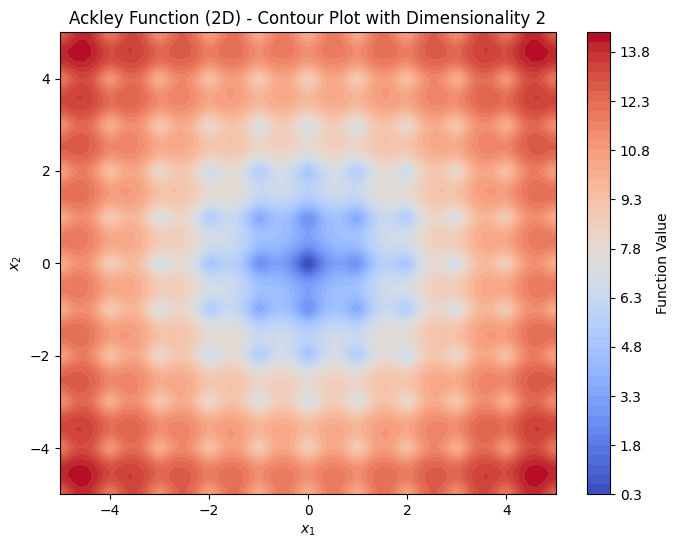

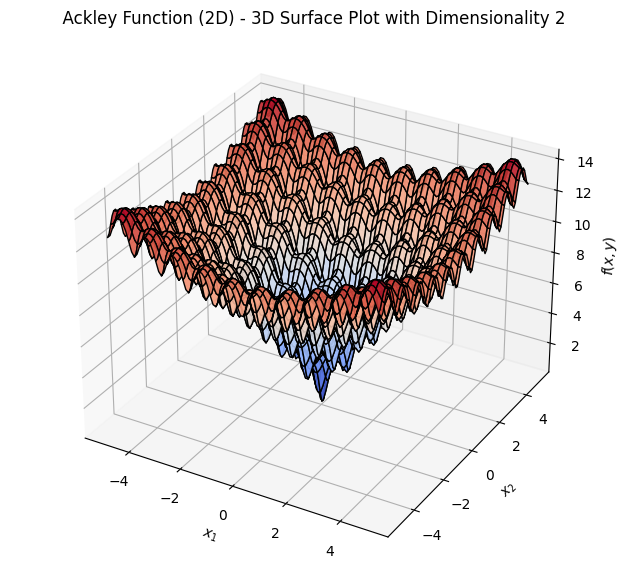

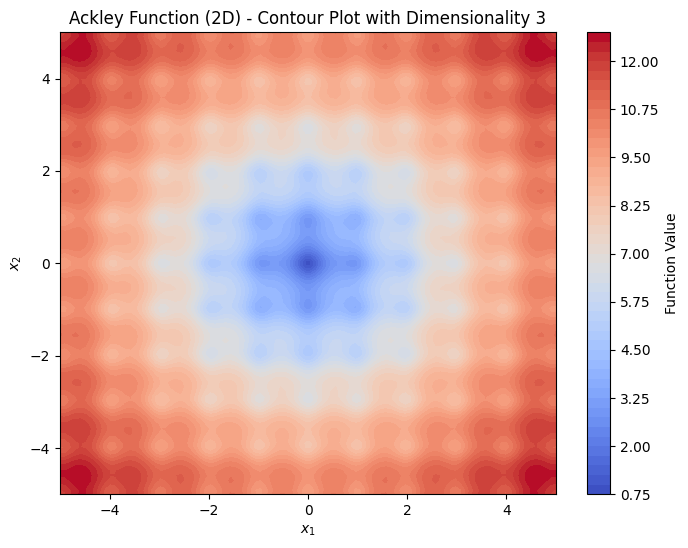

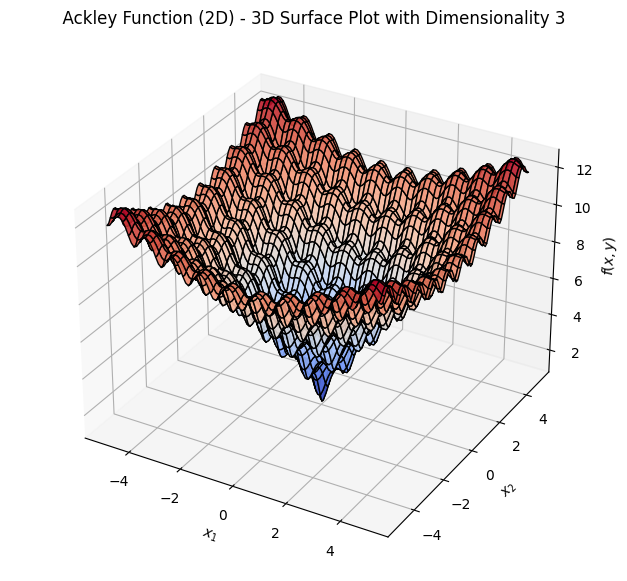

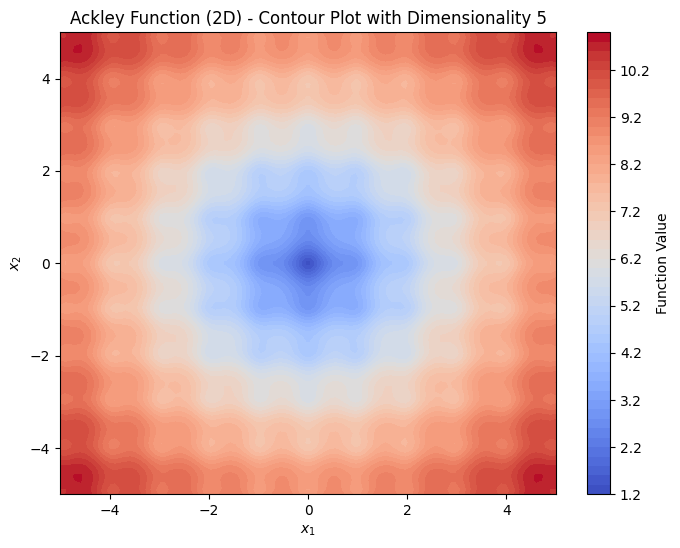

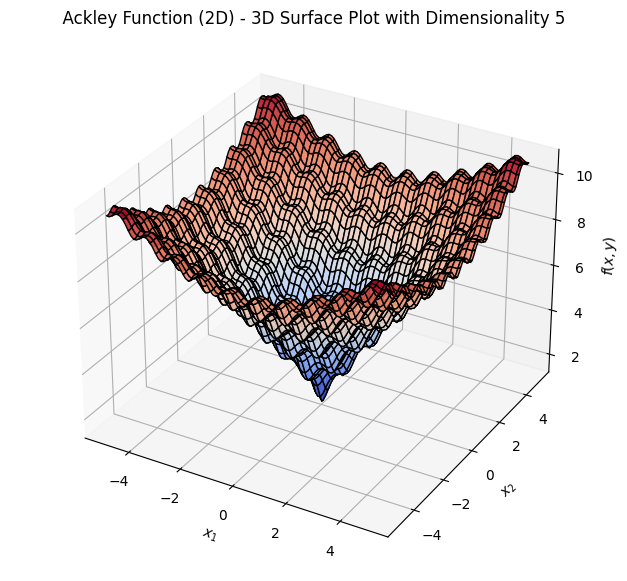

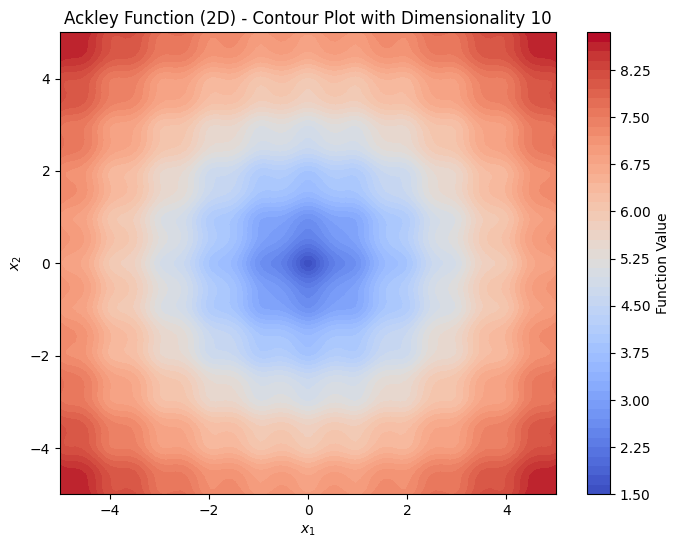

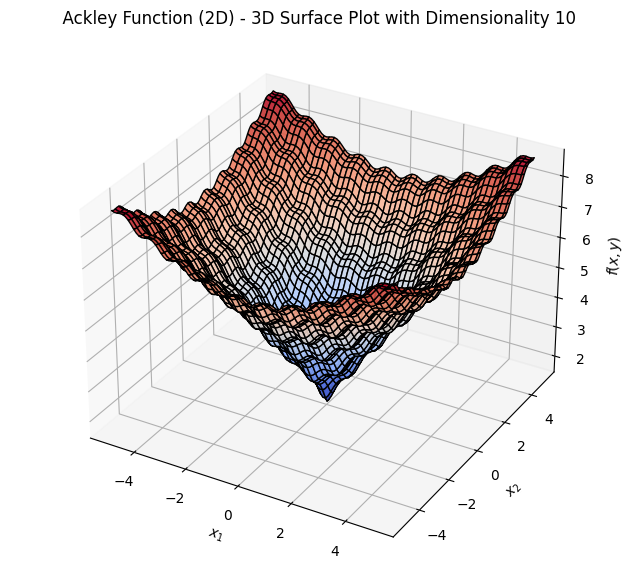

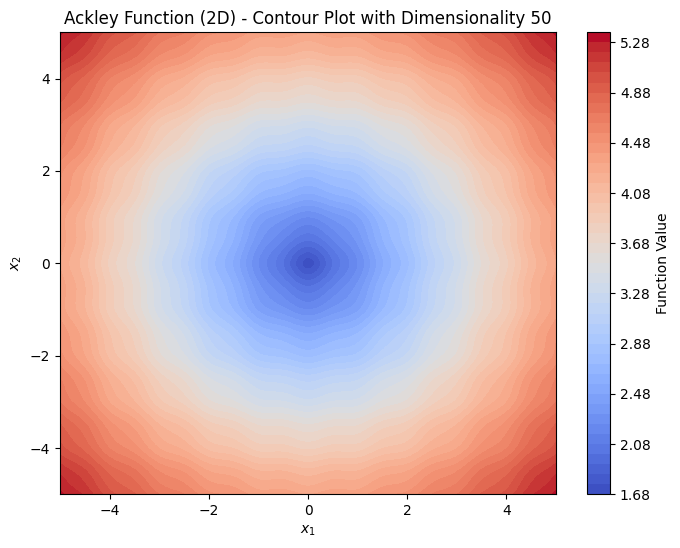

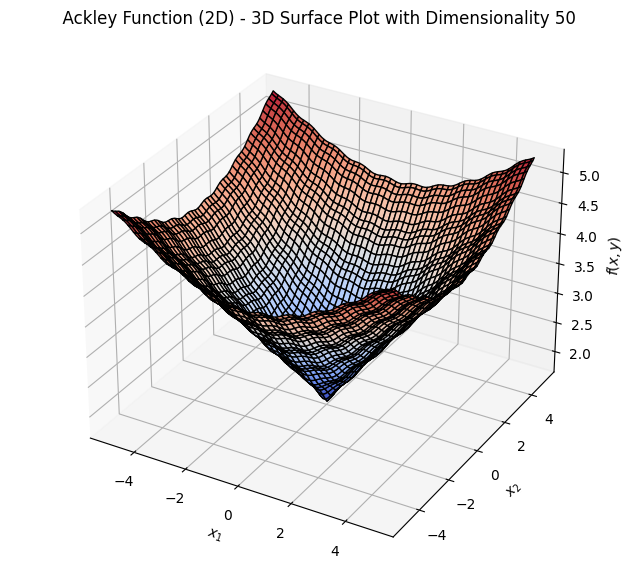

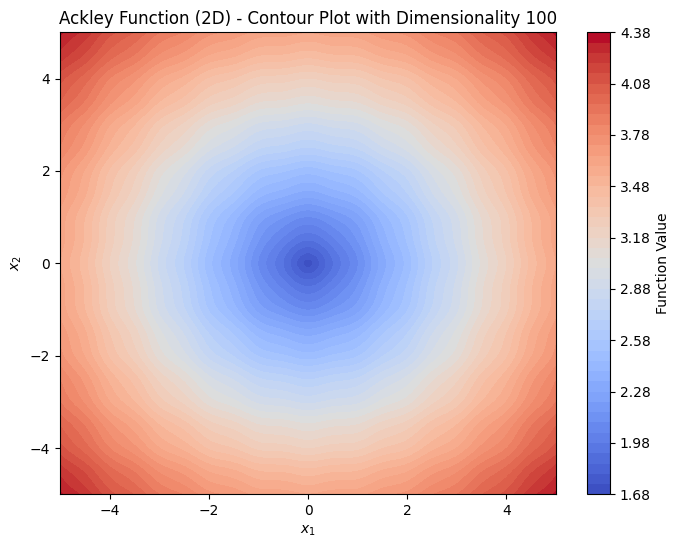

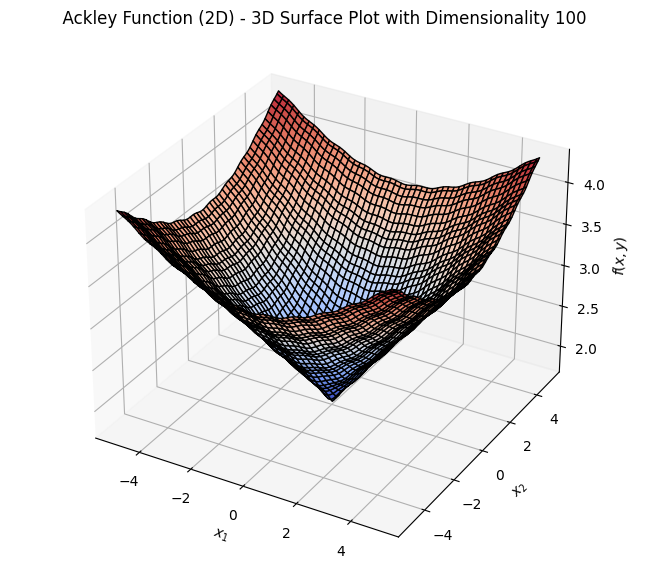

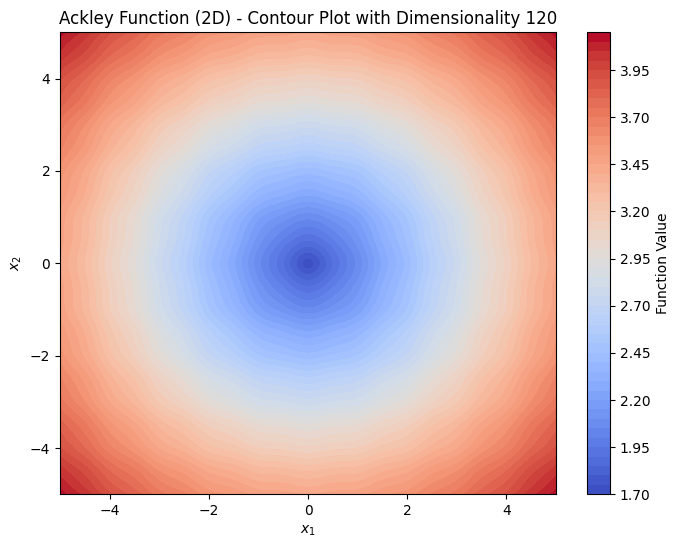

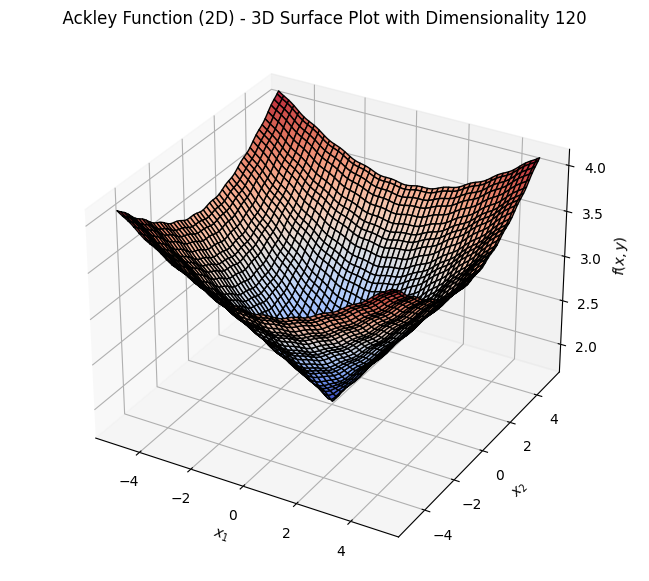

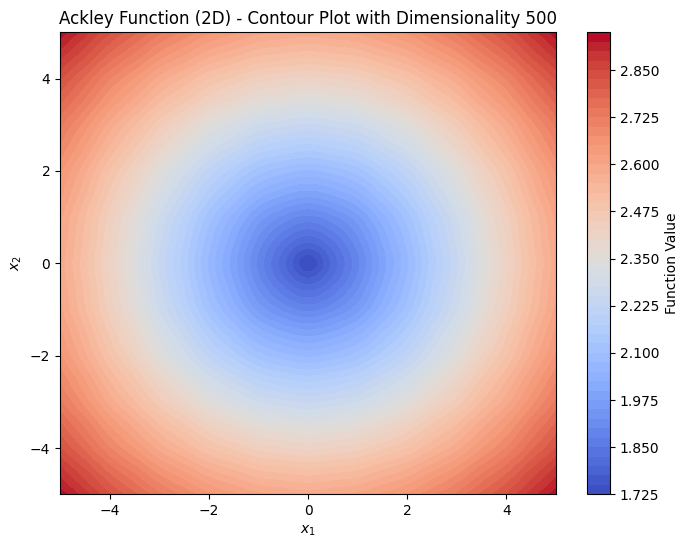

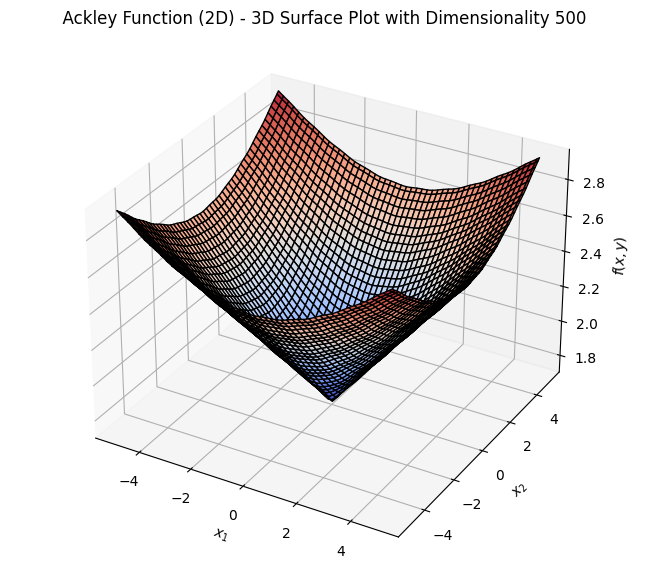

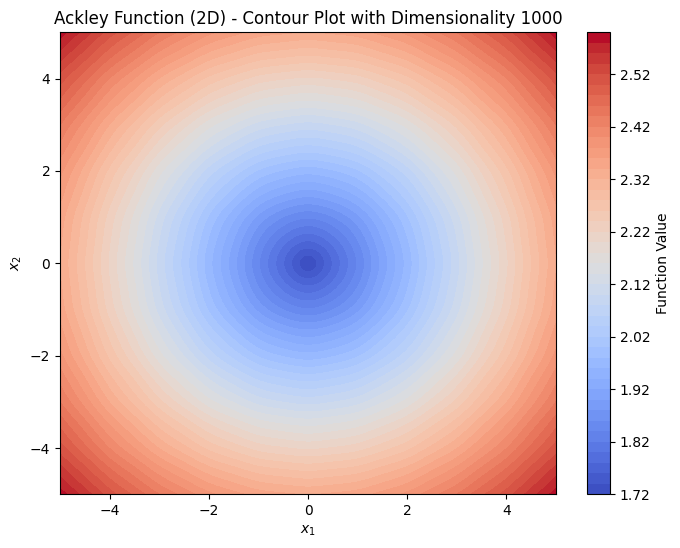

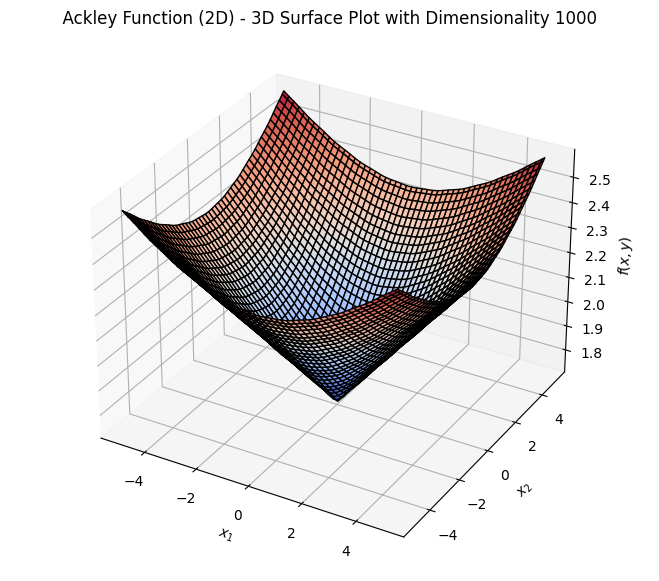

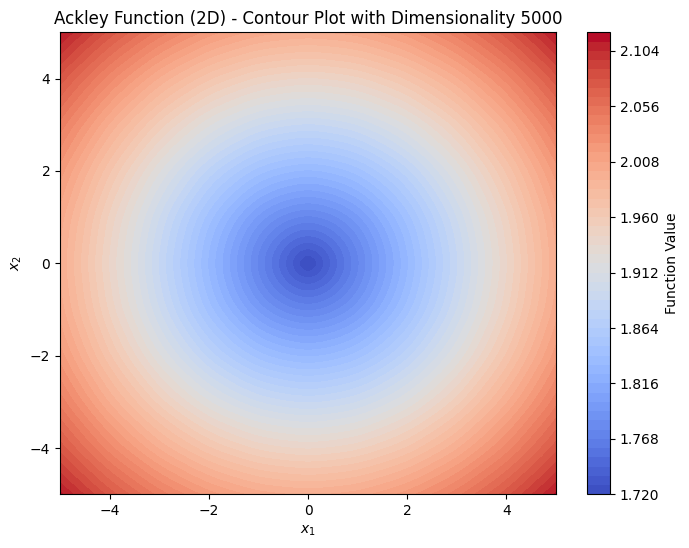

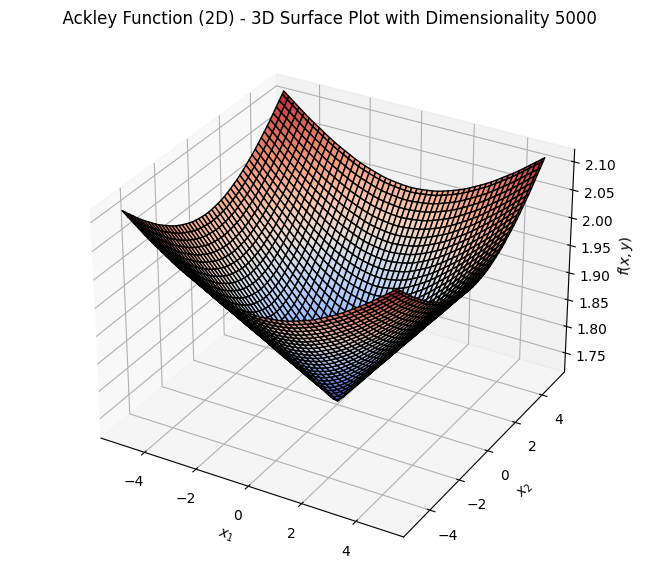

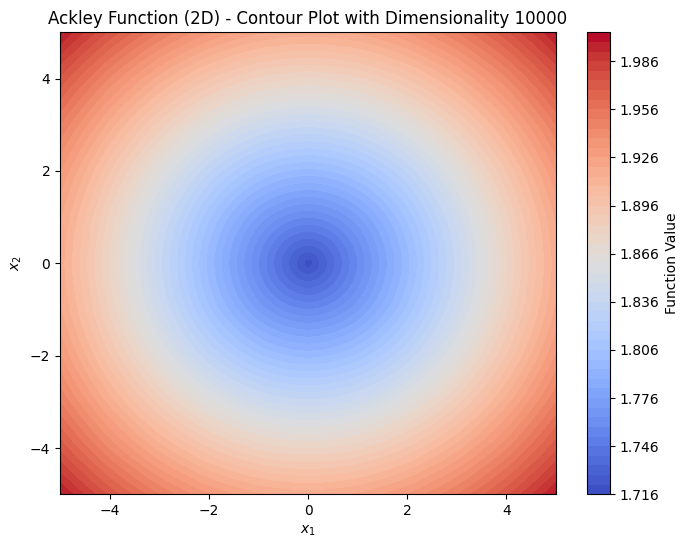

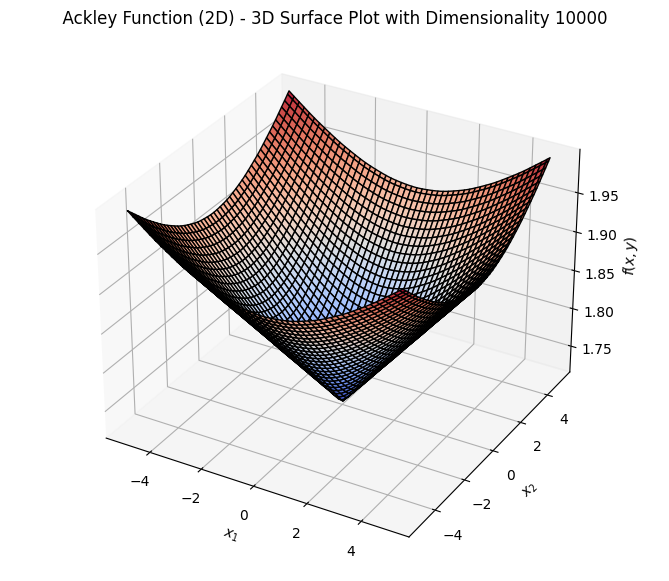

In [33]:
def ackley_for_plotting(x, y, d, a=20, b=0.2, c=2*np.pi):
    sum_sq_term = -a * np.exp(-b * np.sqrt((x**2 + y**2) / d))
    cos_term = -np.exp((np.cos(c * x) + np.cos(c * y)) / d)
    return sum_sq_term + cos_term + a + np.exp(1)

# Generate mesh grid for x and y in range [-5,5]
x_vals = np.linspace(-5, 5, 100)
y_vals = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x_vals, y_vals)

for i in [0.1, 0.5, 1, 2, 3, 5, 10, 50, 100, 120, 500, 1000, 5000, 10000]:
    d = i
    Z = ackley_for_plotting(X, Y, d) # Compute function values
    # Plot Contour
    plt.figure(figsize=(8, 6))
    contour = plt.contourf(X, Y, Z, levels=50, cmap="coolwarm")
    plt.colorbar(label="Function Value")
    plt.title("Ackley Function (2D) - Contour Plot with Dimensionality "+str(d))
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.show()

    # Plot 3D Surface
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap="coolwarm", edgecolor="k", alpha=0.9)
    ax.set_title(10*" "+"Ackley Function (2D) - 3D Surface Plot with Dimensionality "+str(d)+10*" ")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_zlabel("$f(x, y)$")
    plt.show()

Having a non integer dimension, here, means that we are dealing with fractals. By definition, we cannot have $d$ to be a non integer. However, for demonstration purposes, it is there to show the viewer or grader how such a representation would appear visually.

### Experimenting Ackley with Other Factors

NOW INSTEAD OF EXPIMENTING WITH DIMENSIONALITY,
WE WILL EXPERIMENT WITH HEIGHT,
RATE OF EXPONENTIAL DECAY, AND FREQUENCY OF OSCILLATIONS


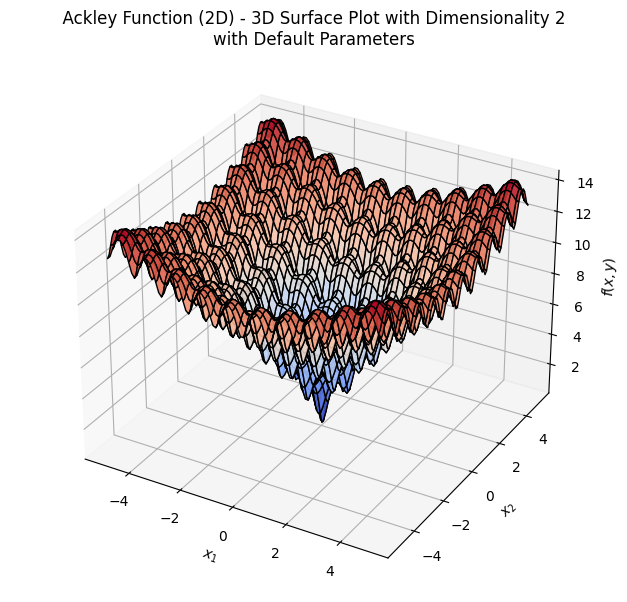

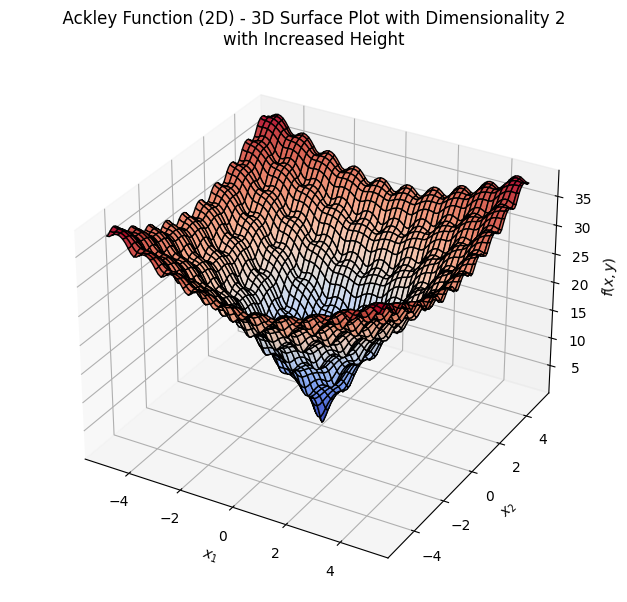

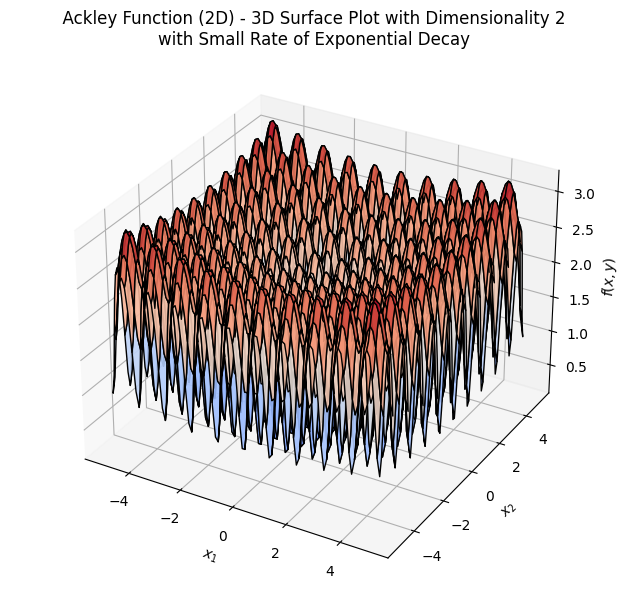

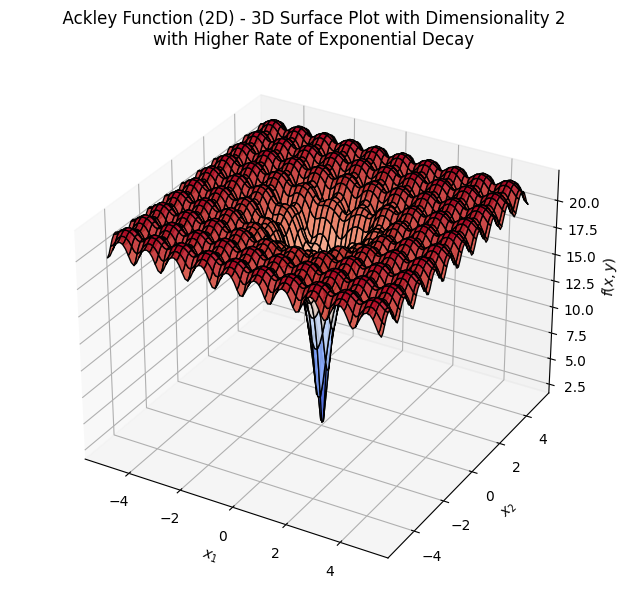

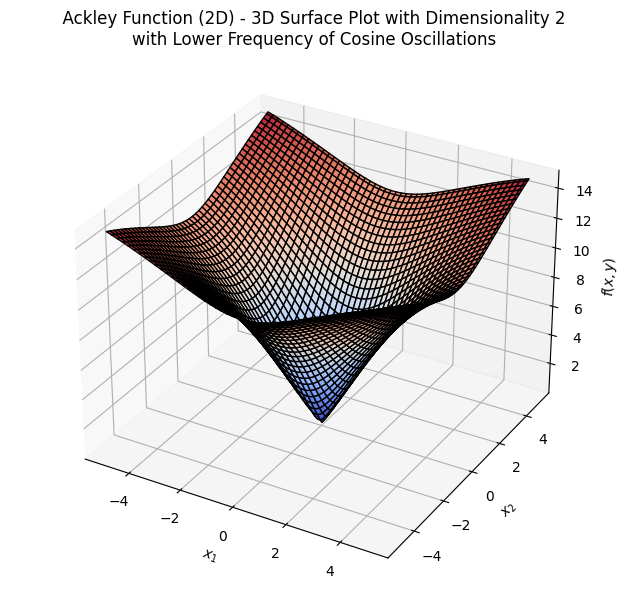

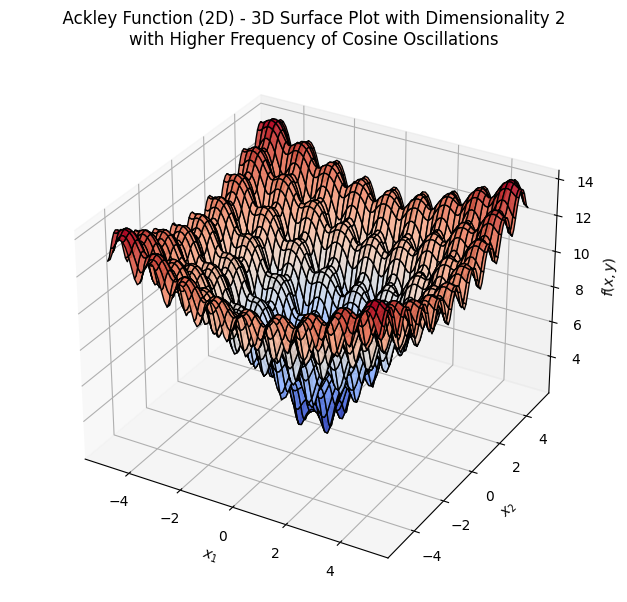

In [34]:
print("NOW INSTEAD OF EXPIMENTING WITH DIMENSIONALITY,\nWE WILL EXPERIMENT WITH HEIGHT,\nRATE OF EXPONENTIAL DECAY, AND FREQUENCY OF OSCILLATIONS")

d = 2
Z=ackley_for_plotting(X, Y, d=d)
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap="coolwarm", edgecolor="k", alpha=0.9)
ax.set_title(10*" "+"Ackley Function (2D) - 3D Surface Plot with Dimensionality "+str(d)+10*" "+"\nwith Default Parameters")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$f(x, y)$")
plt.show()
Z=ackley_for_plotting(X, Y, d=2, a=60)
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap="coolwarm", edgecolor="k", alpha=0.9)
ax.set_title(10*" "+"Ackley Function (2D) - 3D Surface Plot with Dimensionality "+str(d)+10*" "+"\nwith Increased Height")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$f(x, y)$")
plt.show()
Z=ackley_for_plotting(X, Y, d=2, b=0.01)
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap="coolwarm", edgecolor="k", alpha=0.9)
ax.set_title(10*" "+"Ackley Function (2D) - 3D Surface Plot with Dimensionality "+str(d)+10*" "+"\nwith Small Rate of Exponential Decay")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$f(x, y)$")
plt.show()
Z=ackley_for_plotting(X, Y, d=2, b=2)
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap="coolwarm", edgecolor="k", alpha=0.9)
ax.set_title(10*" "+"Ackley Function (2D) - 3D Surface Plot with Dimensionality "+str(d)+10*" "+"\nwith Higher Rate of Exponential Decay")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$f(x, y)$")
plt.show()
Z=ackley_for_plotting(X, Y, d=2, c=np.pi/4)
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap="coolwarm", edgecolor="k", alpha=0.9)
ax.set_title(10*" "+"Ackley Function (2D) - 3D Surface Plot with Dimensionality "+str(d)+10*" "+"\nwith Lower Frequency of Cosine Oscillations")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$f(x, y)$")
plt.show()
Z=ackley_for_plotting(X, Y, d=2, c=18*np.pi)
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap="coolwarm", edgecolor="k", alpha=0.9)
ax.set_title(10*" "+"Ackley Function (2D) - 3D Surface Plot with Dimensionality "+str(d)+10*" "+"\nwith Higher Frequency of Cosine Oscillations")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$f(x, y)$")
plt.show()